# LSTM

In [1]:
# utility
import numpy as np 
import pandas as pd 
import string
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# model 
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
import keras
from keras.utils.np_utils import to_categorical

#nltk and sklearn
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# File path
import os
import os.path
from os import path

# Translator
import googletrans
from googletrans import Translator

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

### Data

In [2]:
# original hindi file
filename  = 'Eng-Hin-data/hindi-anot-shuffled'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.columns = ['Text', 'Label']

In [3]:
# Displaying eg tweet before translation
orig_df.Text[6]

"'आज के दिन ही मेरा क्रिकेट प्रेम भी समाप्त हो गया"

In [4]:
# For non English data

if not path.exists(filename + '-translated.csv'):
    p_data = pd.read_csv("Eng-Hin-data/hindi-anot-shuffled.csv")
    #data =  data.drop('Strength',1)
    translator = Translator()
    col_one_list = p_data['Text'].tolist()
    len(col_one_list)
    result = []
    for i  in range(len(col_one_list)):
        try:
            trans = translator.translate(col_one_list[i], dest='en', model = 'nmt')
            result.append(trans.text)
        except:
                result.append(col_one_list[i])
    p_data['Text'] = result
    p_data.to_csv(filename + '-translated.csv', index=False)
    df = pd.read_csv(filename + '-translated.csv',  
                   delimiter=',')
    df.columns = ['Text', 'Label']
    df.head(15)
    df["Text"] = df["Text"].astype(str)
    df["Label"] = df["Label"].astype(str)
    data = df
    print("Not Exist")
else:
    print("Exist")
    df = pd.read_csv(filename + '-translated.csv',  
                   delimiter=',')
    df.columns = ['Text', 'Label']
    df.head(15)
    df["Text"] = df["Text"].astype(str)
    df["Label"] = df["Label"].astype(str)
    data = df

Exist


In [5]:
df.Text[6]

"'Today also my cricket love has ended"

In [6]:
sentiment =  data['Label'].values

In [7]:
data.groupby('Label').describe()

Text                                                               
      count unique                                                top freq
Label                                                                     
0      3245   3223  Seeing this, Dhoni and Raina retired from cric...    3
1      2172   2142  Happy Islamic New Year "1442 Hijri" to 'Alam-e...    5
2      3373   3360  'Bangalore riots: Jihadi blueprint from Delhi ...    3

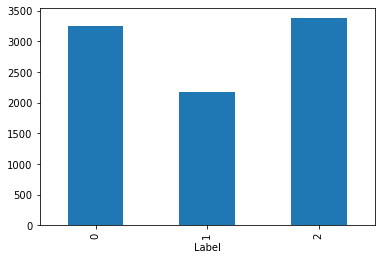

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [9]:
# For entire dataset sentences for each labels 
df.Label.value_counts()

2    3373
0    3245
1    2172
Name: Label, dtype: int64

### Balanced Data

In [10]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [11]:
new_text, new_label = balanceClasses(df['Text'], df['Label'])

In [12]:
data = pd.DataFrame(new_text)
data.columns = ['Text']
data['Label'] = new_label
data = pd.concat([df, data])

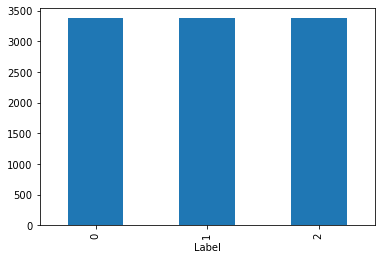

In [13]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [14]:
data.Label.value_counts()

2    3373
1    3372
0    3372
Name: Label, dtype: int64

In [15]:

data=data.sample(frac=1).reset_index(drop=True)
data

,Text,Label
0,'@aajtak @chitraaum Sushant Singh Rajput case ...,0
1,Jihadi has come on the road,2
2,'Chusalman @asadowaisi masjid ka opening karta...,1
3,'@Acharyapramodak O Jihadi Gutter Ki Suvar Tu ...,2
4,'Unable to warrant non-bailable warrant to Muh...,0
...,...,...
10112,'Are you alive in Bollywood? JNU Jamia Shaheen...,2
10113,@ Dharmeen 2653239 @ Pratap: Buddhist 1 @ Heig...,1
10114,"Absolute truth, worship God in Jama Masjid, th...",2
10115,'May Allah always show you happiness and progr...,1


### Data Preprocessing

In [16]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [17]:
def CleanTokenize(df):
    tweets = list()
    lines = data["Text"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            line = clean_text(line)
        else:
            continue
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        tweets.append(words)
    return tweets

def Tokenize(df):
    tweets = list()
    lines = data["Text"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            # tokenize the text
            tokens = word_tokenize(line)
        else:
            continue

        tweets.append(tokens)
    return tweets

tweets = CleanTokenize(data)
#tweets = Tokenize(data)


(-0.5, 999.5, 499.5, -0.5)

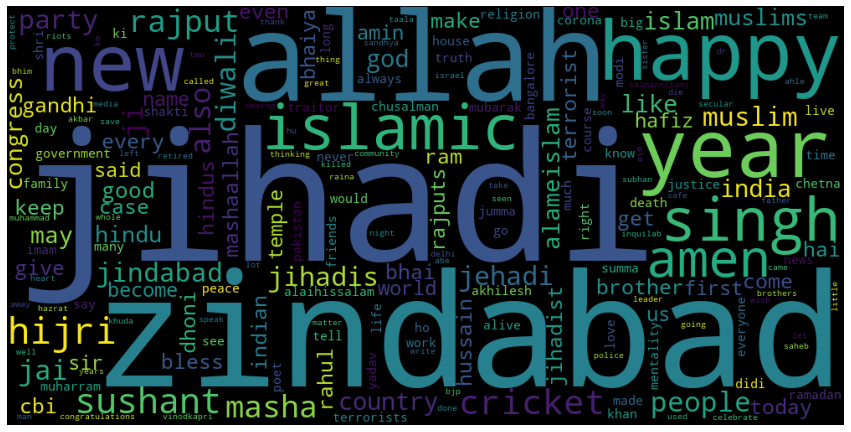

In [18]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['Label'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

### Splitting data

In [22]:
validation_split = 0.1
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tweets)
sequences = tokenizer_obj.texts_to_sequences(tweets)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['Label'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

le = LabelEncoder()
sentiment = le.fit_transform(sentiment)
# transfor from a array to a vector
sentiment = sentiment.reshape(-1,1)


num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]

X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


unique tokens -  12980
vocab size - 12981


In [23]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (9106, 25)
Shape of y_train: (9106, 3)
Shape of X_test_pad: (1011, 25)
Shape of y_test: (1011, 3)


### Glove from paper DSWI

In [24]:
embeddings_index = {}

# Glove from paper DSWI
f = open('Online_supplement_1 word vectors.csv', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))



Found 1181931 word vectors.


In [25]:
embedding_dim = 50

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector

In [26]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

## LSTM Model

In [27]:
def createModel(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.50))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.RMSprop(learning_rate=1e-3), metrics=['acc'])
    return model

model = createModel(embedding_layer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 50)            649050    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               314368    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 964,189
Trainable params: 315,139
Non-trainable params: 649,050
_________________________________________________________________


In [28]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=6, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/6
285/285 - 24s - loss: 1.1002 - acc: 0.3355 - val_loss: 1.1006 - val_acc: 0.3264
Epoch 2/6
285/285 - 23s - loss: 1.1015 - acc: 0.3311 - val_loss: 1.0990 - val_acc: 0.3314
Epoch 3/6
285/285 - 23s - loss: 1.0994 - acc: 0.3341 - val_loss: 1.0988 - val_acc: 0.3264
Epoch 4/6
285/285 - 23s - loss: 1.0991 - acc: 0.3321 - val_loss: 1.0986 - val_acc: 0.3314
Epoch 5/6
285/285 - 23s - loss: 1.0993 - acc: 0.3334 - val_loss: 1.0989 - val_acc: 0.3314
Epoch 6/6
285/285 - 23s - loss: 1.1014 - acc: 0.3280 - val_loss: 1.0988 - val_acc: 0.3314


In [29]:
results = model.evaluate(X_test_pad, y_test, batch_size=32)

32/32 [==============================] - 1s 18ms/step - loss: 1.0988 - acc: 0.3314


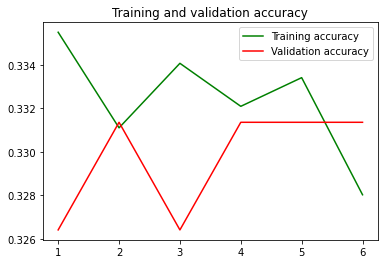

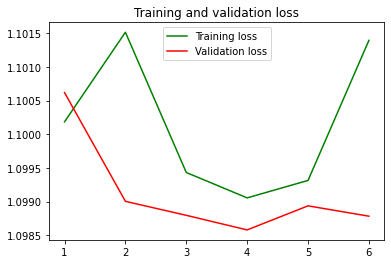

In [30]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 10 Fold cross validation

In [31]:
import random
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import KFold
# KFold cross-validation
kFold = 10
scores = []
validation_split = 0.1
max_length = 25
results = []
print("LSTM with Glove from DSWI: ")
for i in range(kFold):
    print("Fold: ", i+1)
    prediction_val = []
    Y_test = []
    scores=[]
    random_shuff = random.randint(1, 7000)
    X_train_pad, X_test_pad, y_train, y_test = train_test_split(lines_pad, to_categorical(sentiment), test_size=0.10, shuffle = True, random_state=random_shuff)
    model = createModel(embedding_layer)
    history = model.fit(X_train_pad, y_train, batch_size=32, epochs=6, validation_data=(X_test_pad, y_test), verbose=1)
    
    print("Results for current fold:")
    results.append(model.evaluate(X_test_pad, y_test, batch_size=128))
    
    y_pred = model.predict(X_test_pad)
    for p in y_pred:
        prediction_val.append(np.argmax(p))
    for t in y_test:
        Y_test.append(np.argmax(t))
    scoreValue = accuracy_score(Y_test,prediction_val)
    scores.append(scoreValue)



LSTM with Glove from DSWI: 
Fold:  1
Epoch 1/6
285/285 [==============================] - 23s 82ms/step - loss: 1.0995 - acc: 0.3327 - val_loss: 1.0992 - val_acc: 0.3123
Epoch 2/6
285/285 [==============================] - 23s 80ms/step - loss: 1.0992 - acc: 0.3249 - val_loss: 1.0989 - val_acc: 0.3458
Epoch 3/6
285/285 [==============================] - 23s 80ms/step - loss: 1.0993 - acc: 0.3296 - val_loss: 1.0989 - val_acc: 0.3123
Epoch 4/6
285/285 [==============================] - 23s 79ms/step - loss: 1.0993 - acc: 0.3316 - val_loss: 1.1000 - val_acc: 0.3123
Epoch 5/6
285/285 [==============================] - 23s 79ms/step - loss: 1.0993 - acc: 0.3286 - val_loss: 1.0994 - val_acc: 0.3123
Epoch 6/6
285/285 [==============================] - 23s 79ms/step - loss: 1.0991 - acc: 0.3326 - val_loss: 1.0983 - val_acc: 0.3419
Results for current fold:
8/8 [==============================] - 0s 43ms/step - loss: 1.0983 - acc: 0.3419
Fold:  2
Epoch 1/6
285/285 [==============================

In [32]:
import statistics 

score = []
for i in results:
    score.append(i[1])
x = statistics.mean(score)
    
print("Kfold Mean: ", x)

Kfold Mean:  0.32865612506866454


### Confusion matrix

In [33]:
results2 = confusion_matrix(Y_test,prediction_val)
print ('Confusion Matrix :')
print(results2) 
print ('Accuracy Score :',accuracy_score(Y_test,prediction_val))
print ('Report : ')
print (classification_report(Y_test,prediction_val))

Confusion Matrix :
[[  0   0 363]
 [  0   0 332]
 [  0   0 317]]
Accuracy Score : 0.3132411067193676
Report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       363
           1       0.00      0.00      0.00       332
           2       0.31      1.00      0.48       317

    accuracy                           0.31      1012
   macro avg       0.10      0.33      0.16      1012
weighted avg       0.10      0.31      0.15      1012



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
